## 🦠 Avian Influenza and UK Tourism Analysis (2021–2024)

This project explores the relationship between avian influenza outbreaks and tourist arrivals in the UK from 2021 to 2024 using regionally segmented data. The notebook includes exploratory analysis, predictive modeling (OLS, linear, non-linear), classification, and outlier detection.

### 📁 1. Introduction
- Objective: Predict tourist arrivals based on disease data and regional/time indicators
- Dataset includes 154 records, covering 11 regions, across 4 years (2021–2024)
- Key variables: `Clinical_Sign`, `Tourist arrivals`, regional attributes, and travel purposes

### 📊 2. Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Load dataset
df = pd.read_csv('../datasets/extracted_data.csv')
df.head()

,Year,Quarter,Region,Clinical_Sign,Tourist arrivals,Total Night (million),Tourism spend (million),Holiday,VFR,Business,Study,Other
0,2022,Q1,East England,3.0,305989,2.600,111.6,36764.0,180210,76516,2766,10731
1,2022,Q1,East Midlands,NaN,135656,1.400,58.8,7657.0,76717,47885,100,2166
2,2022,Q1,London,NaN,1848646,14.400,1700.0,676495.0,714773,341452,15937,99987
3,2022,Q1,North East,NaN,45847,0.588,41.3,2637.0,31460,9649,1177,921
4,2022,Q1,North West,1.0,332868,3.100,189.3,53447.0,145528,79195,200,54471


- The dataset covers quarterly tourism and clinical sign data for different regions.

- Clinical_Sign has missing values (NaN), indicating some quarters did not report any clinical signs.

- Some columns like Holiday, VFR, Business, Study, and Other are likely travel purposes.

- A large city like London has significantly higher tourist arrivals and expenditures, as expected.

In [2]:
df.shape

(154, 12)

- There are 154 rows (region-quarter combinations) and 12 columns before feature engineering.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     154 non-null    int64  
 1   Quarter                  154 non-null    object 
 2   Region                   154 non-null    object 
 3   Clinical_Sign            104 non-null    float64
 4   Tourist arrivals         154 non-null    int64  
 5   Total Night (million)    154 non-null    float64
 6   Tourism spend (million)  154 non-null    float64
 7   Holiday                  154 non-null    float64
 8   VFR                      154 non-null    int64  
 9   Business                 154 non-null    int64  
 10  Study                    154 non-null    int64  
 11  Other                    154 non-null    int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 14.6+ KB


- Clinical_Sign has missing values → needs imputation or a missing-flag
- Quarter and Region are categorical → will need one-hot encoding
- Features are on different scales (e.g., millions vs. counts) → will require scaling
- Data looks clean and ready for EDA, preprocessing, and modeling

In [4]:
# Fill missing values with 0
df['Clinical_Sign_Flagged'] = df['Clinical_Sign'].isna().astype(int)
df['Clinical_Sign'] = df['Clinical_Sign'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     154 non-null    int64  
 1   Quarter                  154 non-null    object 
 2   Region                   154 non-null    object 
 3   Clinical_Sign            154 non-null    float64
 4   Tourist arrivals         154 non-null    int64  
 5   Total Night (million)    154 non-null    float64
 6   Tourism spend (million)  154 non-null    float64
 7   Holiday                  154 non-null    float64
 8   VFR                      154 non-null    int64  
 9   Business                 154 non-null    int64  
 10  Study                    154 non-null    int64  
 11  Other                    154 non-null    int64  
 12  Clinical_Sign_Flagged    154 non-null    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 15.8+ KB


- Clinical_Sign is now fully numeric — good for modeling.

- Clinical_Sign_Flagged is a binary feature:

    - 1 → previously missing value (likely "no data" or "no outbreak")

    - 0 → outbreak reported

- This flag can help identify areas with potential underreporting.

In [5]:
df.head()

,Year,Quarter,Region,Clinical_Sign,Tourist arrivals,Total Night (million),Tourism spend (million),Holiday,VFR,Business,Study,Other,Clinical_Sign_Flagged
0,2022,Q1,East England,3.0,305989,2.600,111.6,36764.0,180210,76516,2766,10731,0
1,2022,Q1,East Midlands,0.0,135656,1.400,58.8,7657.0,76717,47885,100,2166,1
2,2022,Q1,London,0.0,1848646,14.400,1700.0,676495.0,714773,341452,15937,99987,1
3,2022,Q1,North East,0.0,45847,0.588,41.3,2637.0,31460,9649,1177,921,1
4,2022,Q1,North West,1.0,332868,3.100,189.3,53447.0,145528,79195,200,54471,0


- Confirms that the logic for filling missing values and creating the binary indicator was implemented correctly.

In [6]:
# Function to list stastistics summary
def statistics_summary(sample):
    summary_stats = sample.describe()
    summary_stats.loc['median'] = sample.median()
    summary_stats.loc['variance'] = sample.var()
    summary_stats.loc['range'] = sample.max() - sample.min()
    summary_stats.loc['IQR'] = sample.quantile(0.75) - sample.quantile(0.25)
    return summary_stats


# Statistics summary of the sample
numeric_df = df.select_dtypes(include='number')
sum_stats = pd.DataFrame(statistics_summary(numeric_df))
sum_stats.iloc[:,:11]

,Year,Clinical_Sign,Tourist arrivals,Total Night (million),Tourism spend (million),Holiday,VFR,Business,Study,Other,Clinical_Sign_Flagged
count,154.000000,154.000000,1.540000e+02,154.000000,154.000000,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,154.000000
mean,2022.285714,2.941558,6.821850e+05,5.346797,497.660390,2.736023e+05,2.474274e+05,1.151313e+05,7.246461e+03,4.003963e+04,0.324675
std,1.033519,3.592361,1.145011e+06,7.447682,957.016650,6.129282e+05,2.976655e+05,1.769591e+05,1.004558e+04,8.238979e+04,0.469781
min,2021.000000,0.000000,3.666000e+03,0.109500,1.800000,0.000000e+00,2.275000e+03,4.480000e+02,0.000000e+00,0.000000e+00,0.000000
25%,2021.000000,0.000000,1.360670e+05,1.425000,74.900000,1.838475e+04,7.128775e+04,2.410475e+04,1.593250e+03,3.699750e+03,0.000000
50%,2022.000000,2.000000,3.336760e+05,3.000000,180.350000,6.954200e+04,1.544170e+05,6.392100e+04,3.680500e+03,1.049500e+04,0.000000
75%,2023.000000,4.000000,7.185760e+05,5.575000,407.050000,1.903918e+05,2.956465e+05,1.225752e+05,8.732750e+03,3.158950e+04,1.000000
max,2024.000000,18.000000,5.591183e+06,45.500000,4700.000000,3.016943e+06,1.445933e+06,9.464360e+05,6.201100e+04,5.165410e+05,1.000000
median,2022.000000,2.000000,3.336760e+05,3.000000,180.350000,6.954200e+04,1.544170e+05,6.392100e+04,3.680500e+03,1.049500e+04,0.000000
variance,1.068161,12.905059,1.311051e+12,55.467962,915880.868813,3.756810e+11,8.860476e+10,3.131452e+10,1.009137e+08,6.788077e+09,0.220694


- Clinical_Sign:

    - Mean: ~2.94, Max: 18 → indicates presence of extreme values (likely outliers).

    - Median: 2.0, IQR: 4.0 → distribution is right-skewed.

- Tourist arrivals:

    - Mean: ~682,000, but Max: ~5.6 million → highly skewed, London may be dominating.

- Clinical_Sign_Flagged:

    - Mean: ~0.32 → about 32% of rows had missing clinical sign data originally.

    - Binary distribution confirmed with Min = 0 and Max = 1.

--> This table gives a great foundation for understanding variable ranges and justifies why scaling and outlier management may be needed before modeling.

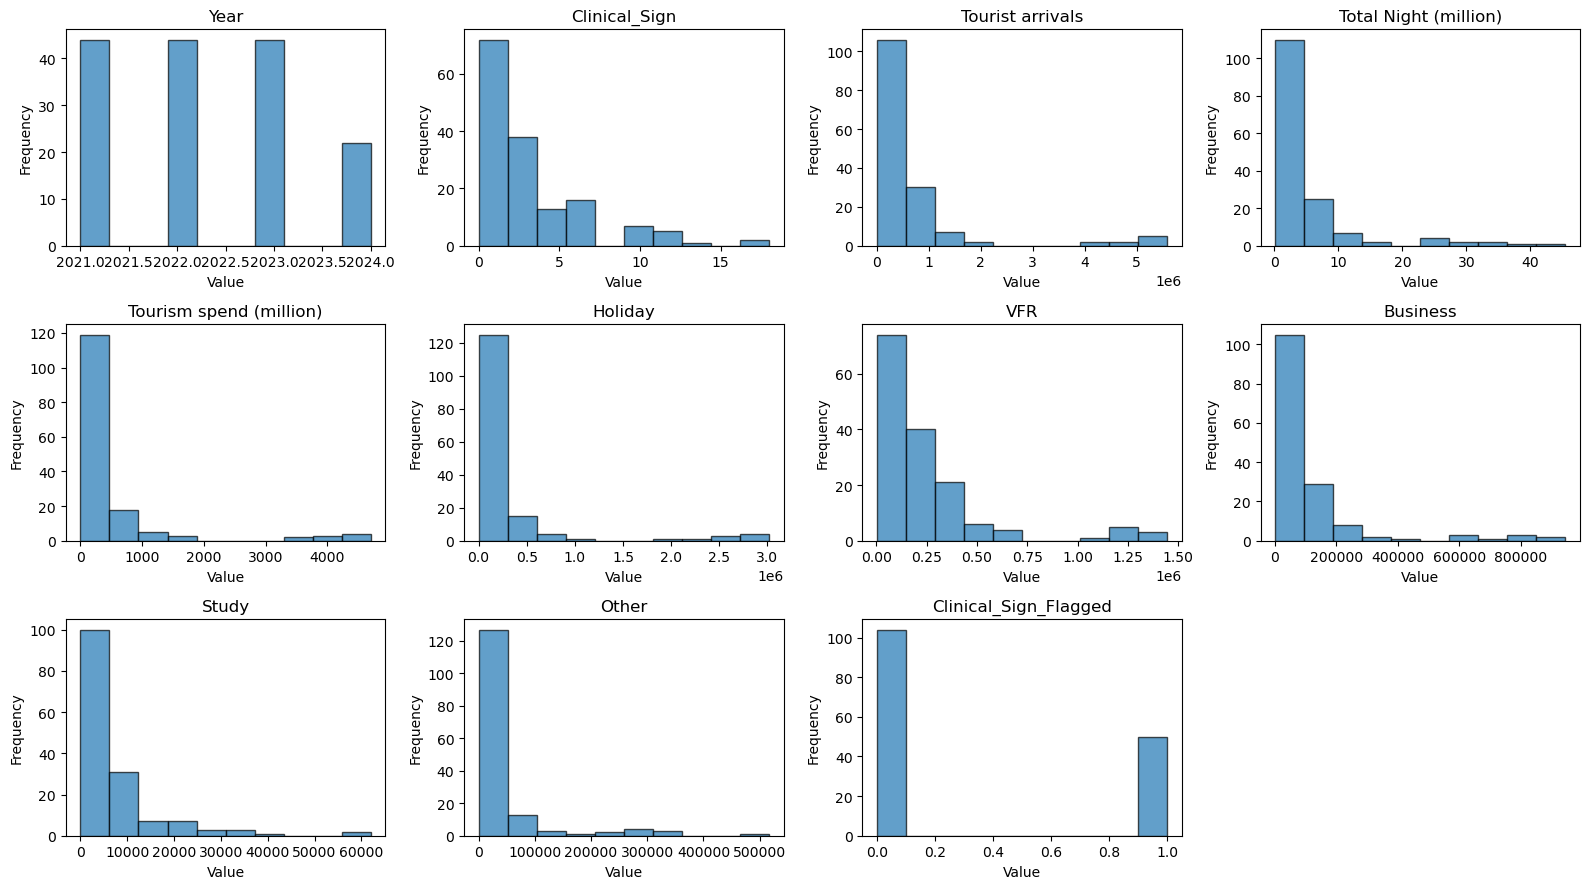

In [7]:
# Function to plot histograms for numeric columns
def plot_hist(data):
    # Automatically detect numeric columns
    numeric_cols = data.select_dtypes(include='number').columns

    # Define subplot layout based on number of numeric columns
    n_cols = 4
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    # Create subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))

    axs = axs.flatten()  # Flatten to easily iterate

    for i, col in enumerate(numeric_cols):
        axs[i].hist(data[col].dropna(), bins=10, alpha=0.7, edgecolor='black')
        axs[i].set_title(col)
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')

    # Remove unused axes
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

plot_hist(df)


- Nearly all variables are right-skewed, which is common for population or economic data.
- Consider log transformation or scaling (e.g., Min-Max, Robust) before applying models that assume normality.
- Potential outliers present — useful for clustering or robust modeling.
- Important to normalize or standardize before using PCA, clustering, or regression.

Year: Shapiro-Wilk p-value = 0.0000 → Data is not normal


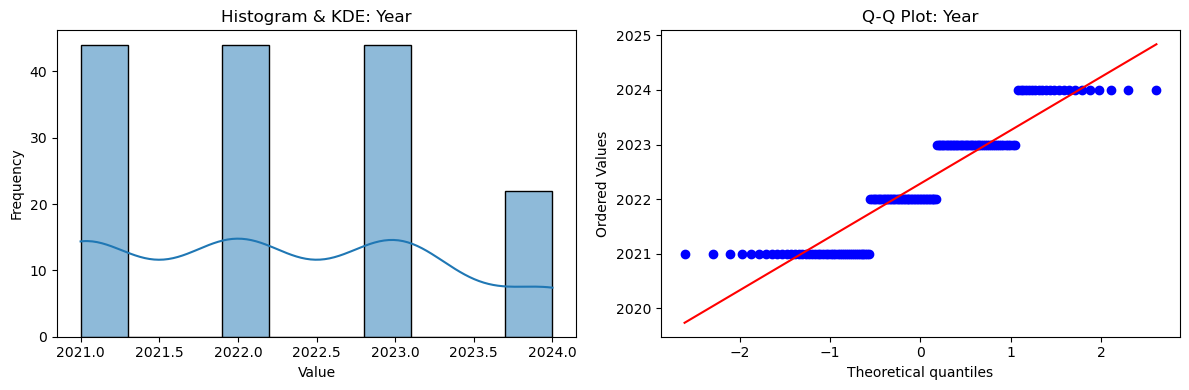

Clinical_Sign: Shapiro-Wilk p-value = 0.0000 → Data is not normal


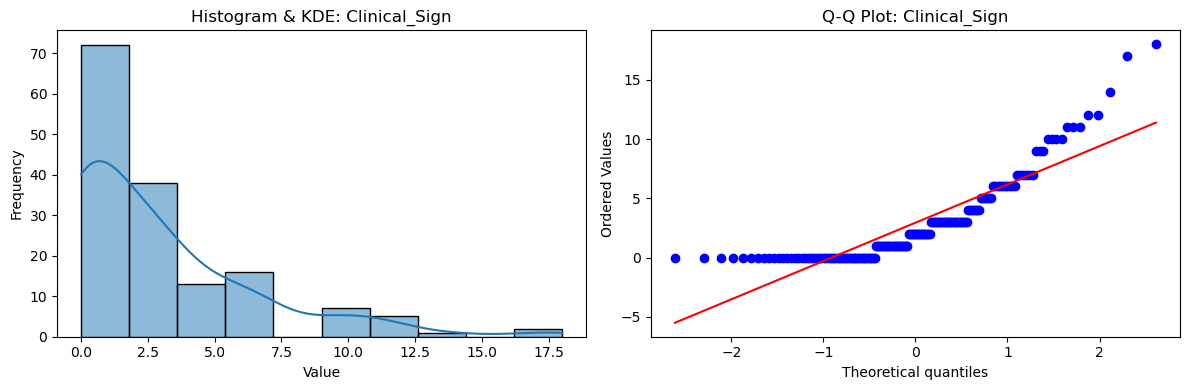

Tourist arrivals: Shapiro-Wilk p-value = 0.0000 → Data is not normal


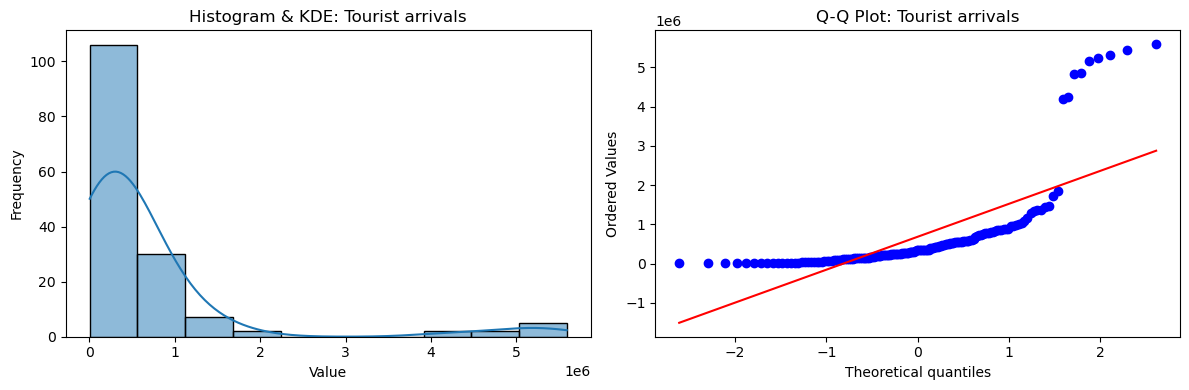

Total Night (million): Shapiro-Wilk p-value = 0.0000 → Data is not normal


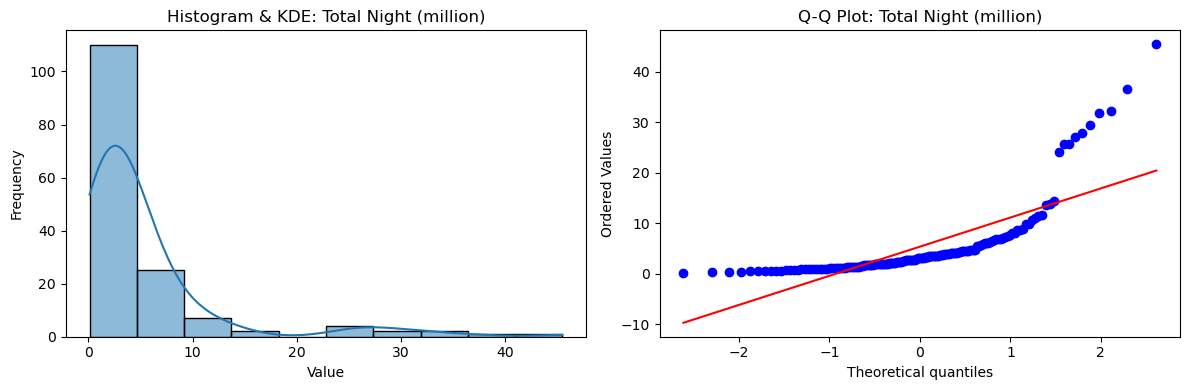

Tourism spend (million): Shapiro-Wilk p-value = 0.0000 → Data is not normal


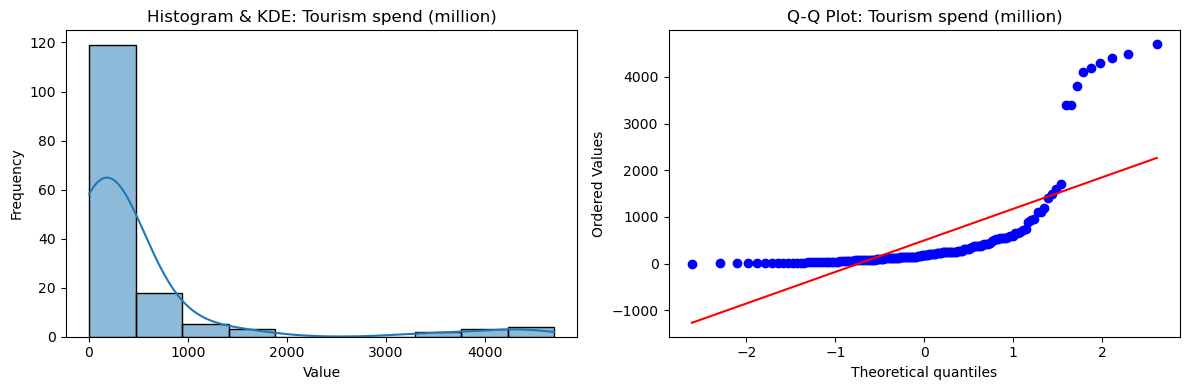

Holiday: Shapiro-Wilk p-value = 0.0000 → Data is not normal


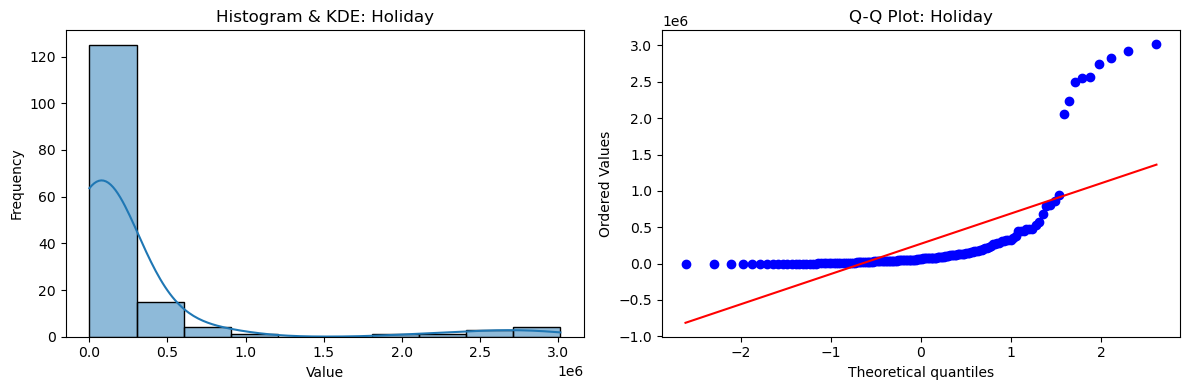

VFR: Shapiro-Wilk p-value = 0.0000 → Data is not normal


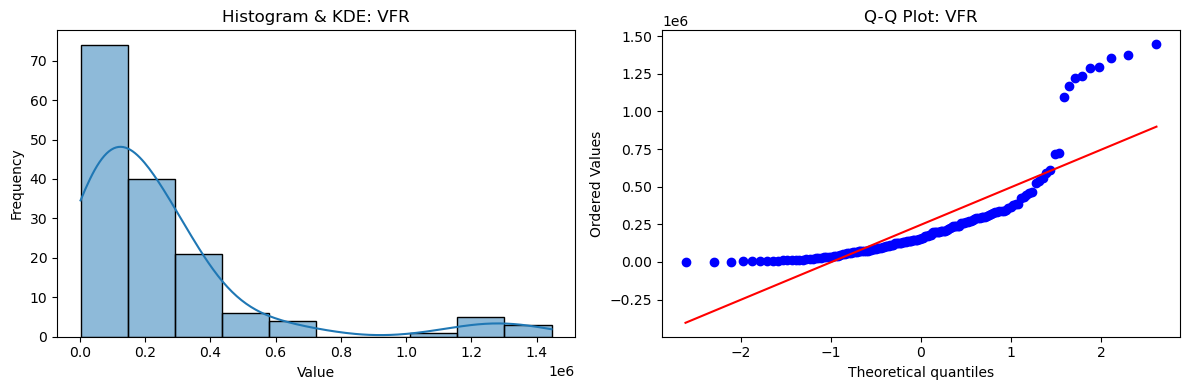

Business: Shapiro-Wilk p-value = 0.0000 → Data is not normal


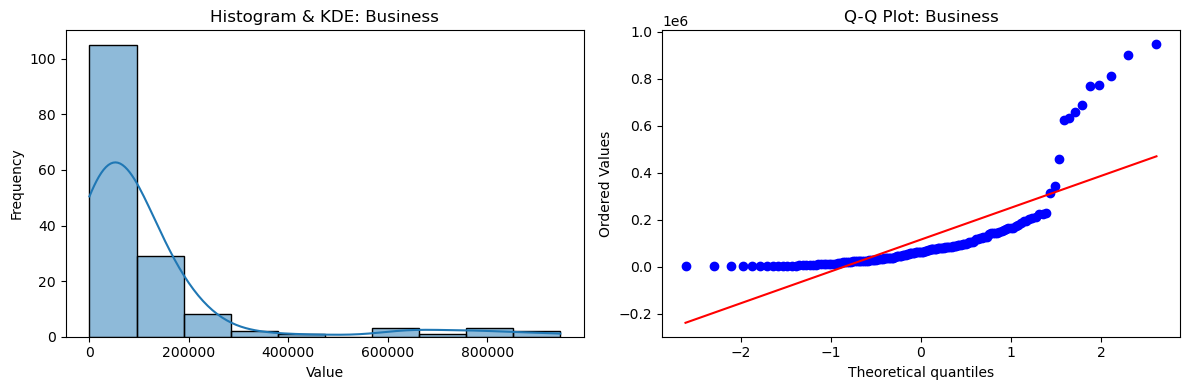

Study: Shapiro-Wilk p-value = 0.0000 → Data is not normal


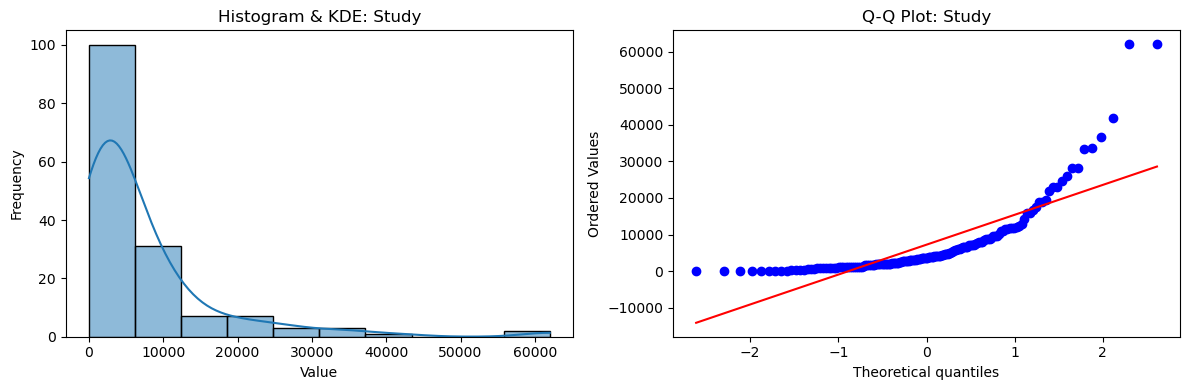

Other: Shapiro-Wilk p-value = 0.0000 → Data is not normal


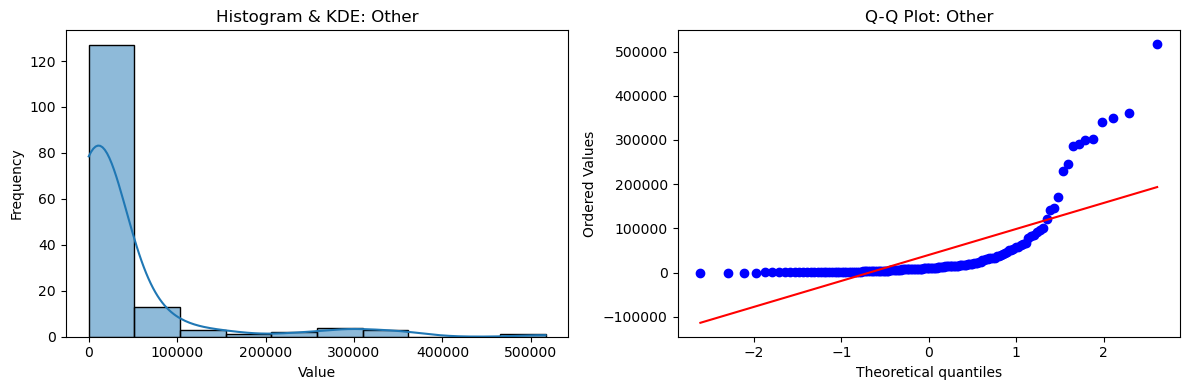

Clinical_Sign_Flagged: Shapiro-Wilk p-value = 0.0000 → Data is not normal


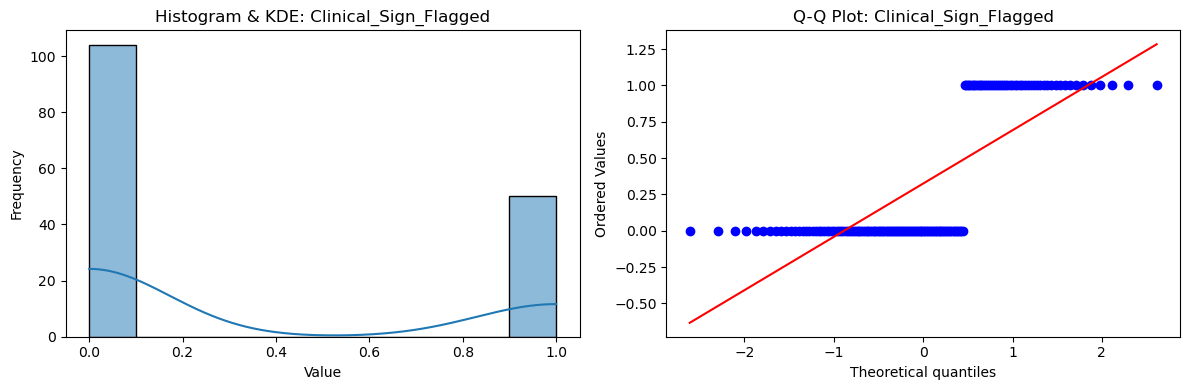

In [8]:
def plot_normality_avian(data):
    # Get numeric columns only
    numeric_cols = data.select_dtypes(include='number').columns

    # Loop through each numeric column
    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Histogram with KDE
        sns.histplot(data[col].dropna(), kde=True, ax=axes[0], bins=10, edgecolor='black')
        axes[0].set_title(f'Histogram & KDE: {col}')
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Frequency')

        # Q-Q Plot
        st.probplot(data[col].dropna(), dist="norm", plot=axes[1])
        axes[1].set_title(f'Q-Q Plot: {col}')

        # Shapiro-Wilk test
        stat, p = st.shapiro(data[col].dropna())
        result = "normal" if p > 0.05 else "not normal"
        print(f"{col}: Shapiro-Wilk p-value = {p:.4f} → Data is {result}")

        plt.tight_layout()
        plt.show()


plot_normality_avian(df)  # Replace df with your avian influenza dataset


We recognize that our dataset does not follow a normal distribution, which is usually a basic requirement for using a t-test. However, we're using this method to keep things similar to a lot of research in this area that have mainly used t-statistics. Readers should note that this violation of assumptions may impact the accuracy of our results, and therefore interpret findings with caution.

In [9]:
def normality_test(sample):
    results = []

    # Filter numeric columns only
    numeric_sample = sample.select_dtypes(include='number')

    for column in numeric_sample.columns:
        data = numeric_sample[column].dropna()

        # Skip if column has too few values
        if len(data) < 8:
            print(f"Column '{column}' has too few observations for normality test.\n")
            continue

        try:
            k2, p = st.normaltest(data)
            normal = 'Not Normal' if p < 0.05 else 'Normal'

            print(f"Column: {column}")
            print(f"k² = {k2:.4f}, p = {p:.4f} → {normal}\n")

            results.append({
                'Column': column,
                'K2 Statistic': k2,
                'p-value': p,
                'Normality': normal
            })

        except Exception as e:
            print(f"Could not test column '{column}': {e}\n")

    return pd.DataFrame(results)


In [10]:
result_df = normality_test(df)

Column: Year
k² = 48.6965, p = 0.0000 → Not Normal

Column: Clinical_Sign
k² = 58.8129, p = 0.0000 → Not Normal

Column: Tourist arrivals
k² = 125.1963, p = 0.0000 → Not Normal

Column: Total Night (million)
k² = 120.7472, p = 0.0000 → Not Normal

Column: Tourism spend (million)
k² = 126.7022, p = 0.0000 → Not Normal

Column: Holiday
k² = 131.6752, p = 0.0000 → Not Normal

Column: VFR
k² = 95.8247, p = 0.0000 → Not Normal

Column: Business
k² = 119.9862, p = 0.0000 → Not Normal

Column: Study
k² = 123.7707, p = 0.0000 → Not Normal

Column: Other
k² = 131.0578, p = 0.0000 → Not Normal

Column: Clinical_Sign_Flagged
k² = 384.2661, p = 0.0000 → Not Normal



- All tested variables returned p < 0.05, meaning none of the variables are normally distributed.

- This is common in real-world economic and tourism data, which are often skewed, non-Gaussian.

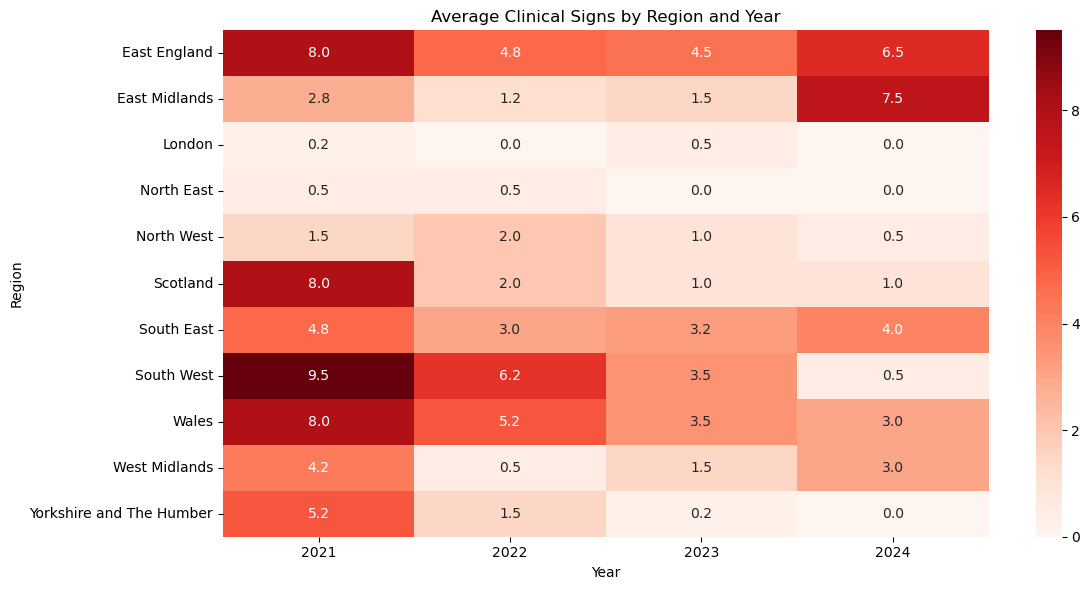

Year                    Region  Cluster             Cluster_Label
0                 East England        2  Moderate Outbreak Region
1                East Midlands        0       Low Outbreak Region
2                       London        0       Low Outbreak Region
3                   North East        0       Low Outbreak Region
4                   North West        0       Low Outbreak Region
5                     Scotland        0       Low Outbreak Region
6                   South East        2  Moderate Outbreak Region
7                   South West        1      High Outbreak Region
8                        Wales        1      High Outbreak Region
9                West Midlands        0       Low Outbreak Region
10    Yorkshire and The Humber        0       Low Outbreak Region
Cluster
0    1.714286
2    4.843750
1    4.937500
dtype: float64


In [11]:
# Calculate average Clinical_Sign per Region per Year
pivot_data = df.groupby(['Region', 'Year'])['Clinical_Sign'].mean().reset_index()

# Pivot to create a Region × Year matrix
pivot_matrix = pivot_data.pivot(index='Region', columns='Year', values='Clinical_Sign').fillna(0)

# Scale the data
scaler = MinMaxScaler()
scaled_matrix = scaler.fit_transform(pivot_matrix)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
pivot_matrix['Cluster'] = kmeans.fit_predict(scaled_matrix)

# Rename clusters
cluster_label_map = {
    0: "Low Outbreak Region",
    2: "Moderate Outbreak Region",
    1: "High Outbreak Region"
}

pivot_matrix['Cluster_Label'] = pivot_matrix['Cluster'].map(cluster_label_map)

# Plot heatmap of average clinical signs by Region and Year
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_matrix.drop(columns=['Cluster', 'Cluster_Label']),
            cmap='Reds', annot=True, fmt=".1f", cbar=True)
plt.title("Average Clinical Signs by Region and Year")
plt.ylabel("Region")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# Print cluster labels
region_clusters = pivot_matrix[['Cluster', 'Cluster_Label']].reset_index()
print(region_clusters)

# Assuming pivot_matrix includes the cluster assignments
cluster_means = pivot_matrix.drop(columns=['Cluster_Label']).groupby('Cluster').mean()
print(cluster_means.mean(axis=1).sort_values())



- London, North East, West Midlands, etc. → Low outbreak regions

- South West, Wales → High outbreak regions

- This makes sense based on poultry/avian distribution in the UK and outbreak patterns.

### 📉 3. Data Visualisation

In [12]:
# Group data
region_summary = df.groupby('Region').agg({
    'Tourist arrivals': 'sum',
    'Clinical_Sign': 'sum'
}).sort_values(by='Tourist arrivals', ascending=False)

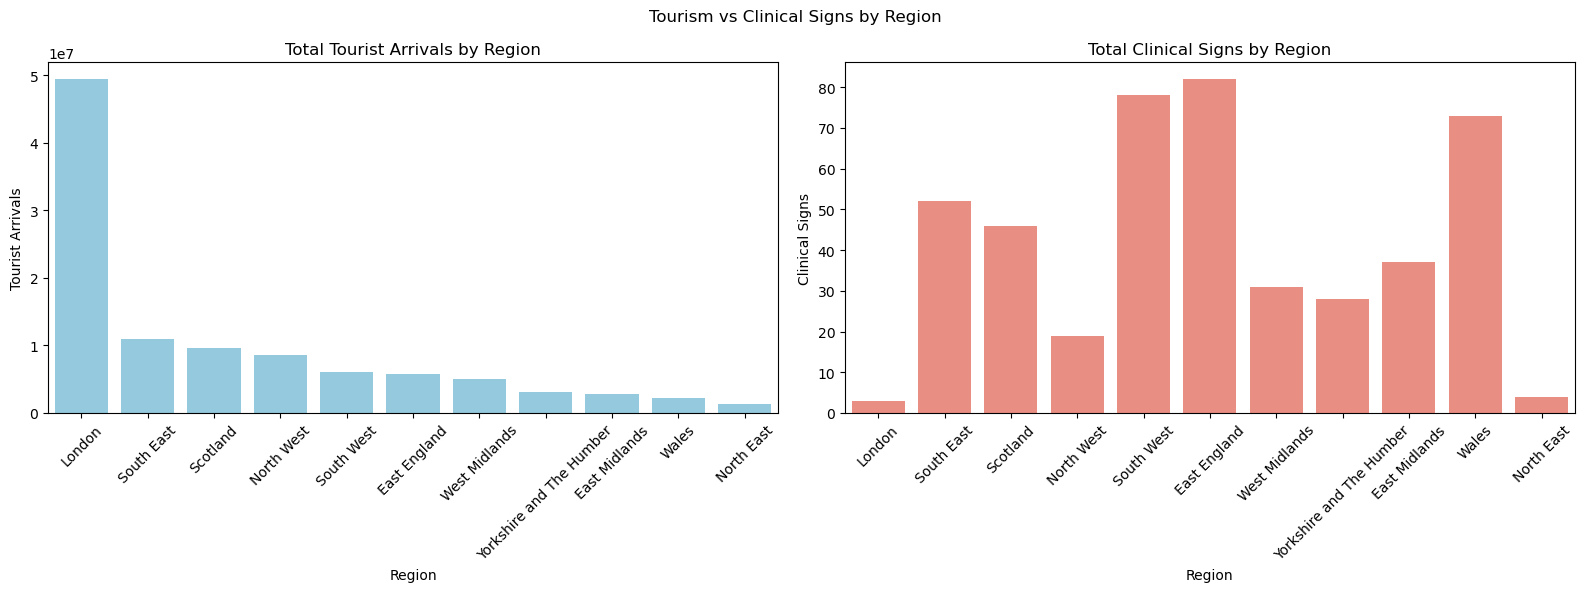

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

sns.barplot(x=region_summary.index, y=region_summary['Tourist arrivals'], ax=ax1, color='skyblue')
ax1.set_title("Total Tourist Arrivals by Region")
ax1.set_ylabel("Tourist Arrivals")
ax1.tick_params(axis='x', rotation=45)

sns.barplot(x=region_summary.index, y=region_summary['Clinical_Sign'], ax=ax2, color='salmon')
ax2.set_title("Total Clinical Signs by Region")
ax2.set_ylabel("Clinical Signs")
ax2.tick_params(axis='x', rotation=45)

plt.suptitle("Tourism vs Clinical Signs by Region")
plt.tight_layout()
plt.show()


- London stands out dramatically as the dominant tourism hub, with nearly 50 million total arrivals — far surpassing all other regions. However, it reports very few clinical signs, suggesting low outbreak presence despite high tourist volume.

- In contrast, regions like East England, South West, and Wales show relatively high clinical signs despite having significantly lower tourist arrivals. This may indicate higher outbreak activity or reporting in less tourist-dense areas.

- Regions such as South East and Scotland maintain moderate levels for both tourism and clinical signs, possibly representing balanced exposure and activity.

- North East consistently ranks low on both metrics, suggesting minimal tourism and limited outbreak activity in this region.

Observational Implications:
- There is no clear linear correlation between tourist arrivals and clinical signs across regions.
- Some regions with high tourism appear protected or better managed against avian outbreaks (e.g., London), while less-touristic regions may be more vulnerable.
- These patterns support the use of cluster analysis or regression modeling to better understand relationships between tourism and avian flu presence.

/var/folders/7q/kcyxkj_x33n739dtp9drhs7r0000gn/T/ipykernel_47887/3261490315.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(regions, rotation=45)


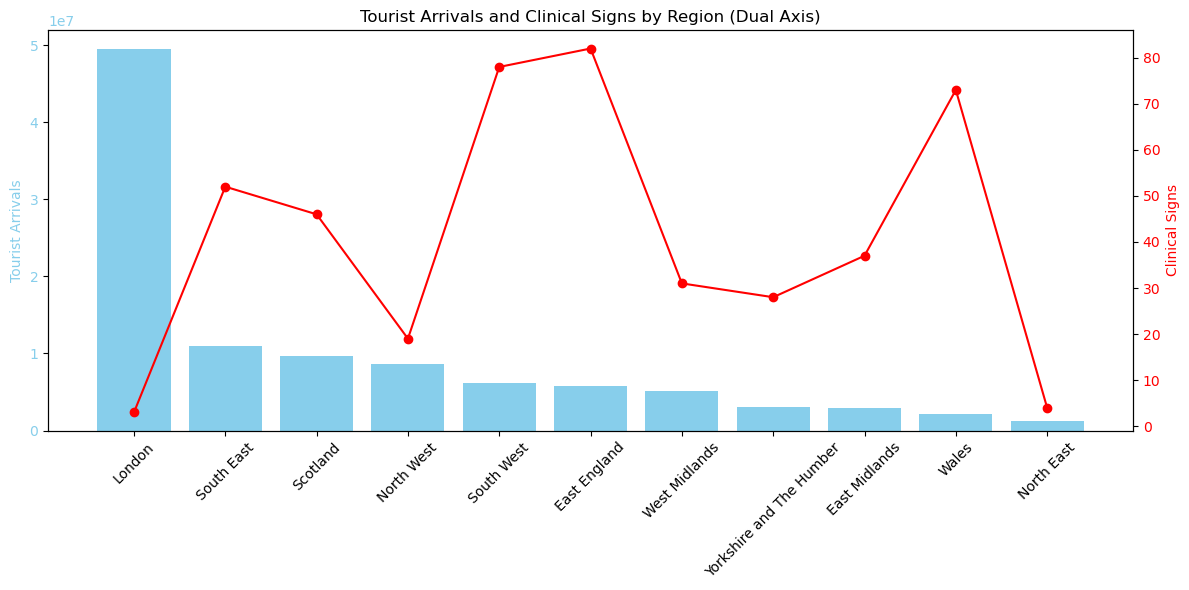

In [14]:
regions = region_summary.index
arrivals = region_summary['Tourist arrivals']
signs = region_summary['Clinical_Sign']

# Plot with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot tourist arrivals
ax1.bar(regions, arrivals, color='skyblue', label='Tourist Arrivals')
ax1.set_ylabel("Tourist Arrivals", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(regions, rotation=45)

# Create a second y-axis for clinical signs
ax2 = ax1.twinx()
ax2.plot(regions, signs, color='red', marker='o', label='Clinical Signs')
ax2.set_ylabel("Clinical Signs", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Tourist Arrivals and Clinical Signs by Region (Dual Axis)")
plt.tight_layout()
plt.show()

Tourist Arrivals vs. Clinical Signs by Region

This dual-axis chart reveals a **regional mismatch** between tourism and outbreak intensity:
- **London** had by far the **highest tourist arrivals** with **very few clinical signs**, indicating a strong tourism sector largely unaffected by outbreaks.
- **South West, East England, and Wales** reported **high numbers of clinical signs** but **low tourist activity**, suggesting outbreaks may have **negatively impacted** tourism in those areas.
- Other regions like the **South East** and **Scotland** had **moderate tourism** and **clinical signs**, pointing to **balanced exposure**.

These findings highlight regions where public health management and tourism promotion may need to be aligned.


In [15]:
quarter_summary = df.groupby(['Year', 'Quarter']).agg({
    'Clinical_Sign': 'sum',
    'Tourist arrivals': 'sum'
}).reset_index()

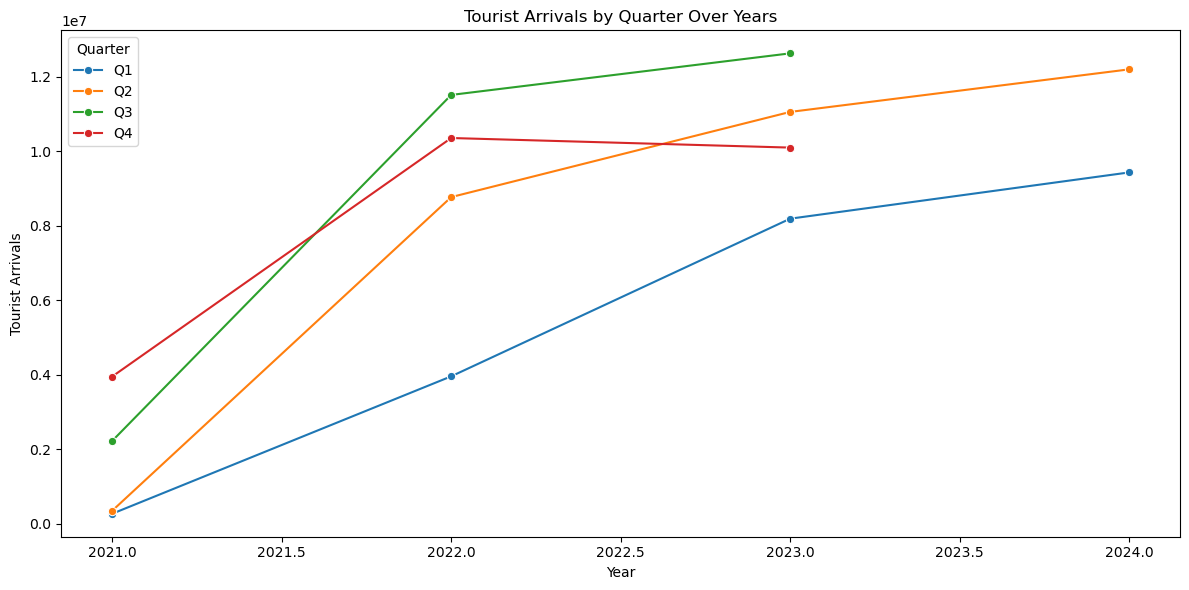

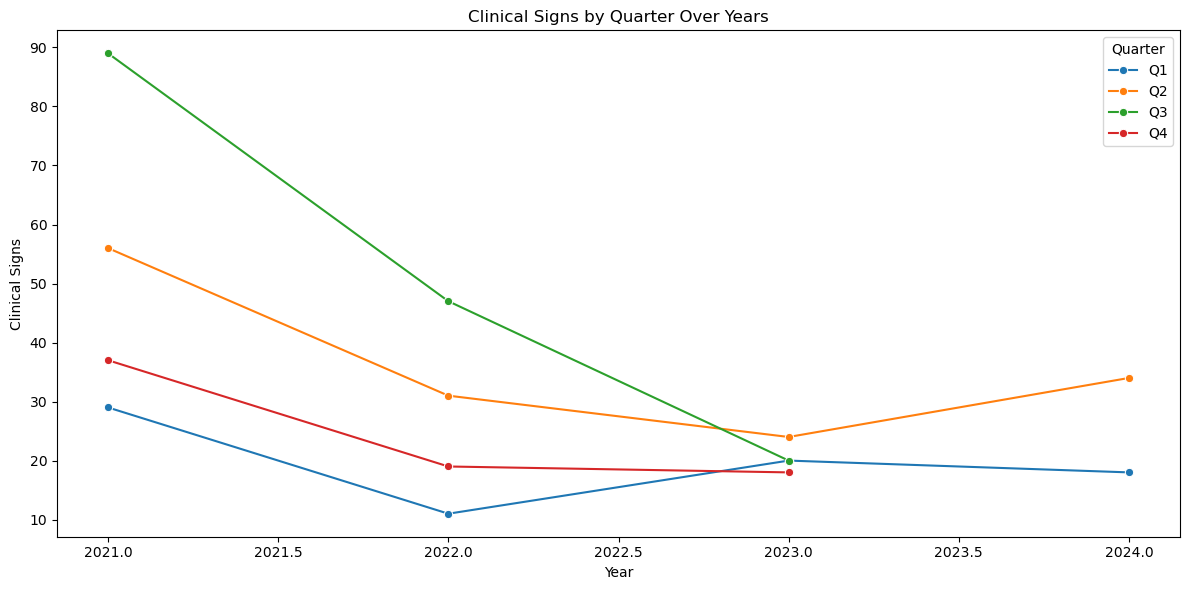

In [16]:
# Plot: Tourist Arrivals over Time by Quarter
plt.figure(figsize=(12, 6))
sns.lineplot(data=quarter_summary, x='Year', y='Tourist arrivals', hue='Quarter', marker='o')
plt.title("Tourist Arrivals by Quarter Over Years")
plt.ylabel("Tourist Arrivals")
plt.tight_layout()
plt.show()

# Plot: Clinical Signs over Time by Quarter
plt.figure(figsize=(12, 6))
sns.lineplot(data=quarter_summary, x='Year', y='Clinical_Sign', hue='Quarter', marker='o')
plt.title("Clinical Signs by Quarter Over Years")
plt.ylabel("Clinical Signs")
plt.tight_layout()
plt.show()

- While tourism is rising, clinical signs are falling — suggesting that the tourism rebound is not being hindered by avian flu outbreaks.

- This divergence may reflect:

    - Improved disease control and response

    - Better awareness and monitoring

    - Or a potential lag effect where outbreaks no longer directly impact travel volumes

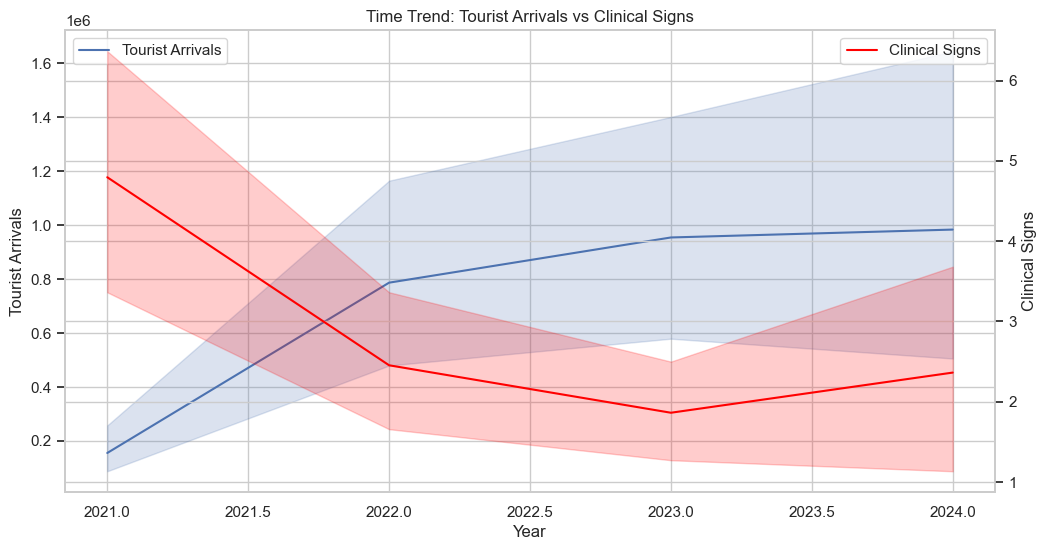

In [17]:
# Time Trends: Clinical Signs vs Tourist Arrivals ---
sns.set(style="whitegrid")
fig1, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df, x="Year", y="Tourist arrivals", label="Tourist Arrivals", ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=df, x="Year", y="Clinical_Sign", color="red", label="Clinical Signs", ax=ax2)
ax1.set_title("Time Trend: Tourist Arrivals vs Clinical Signs")
ax1.set_ylabel("Tourist Arrivals")
ax2.set_ylabel("Clinical Signs")
plt.show()

The chart shows an **inverse trend** between tourist arrivals and clinical signs:
- **Tourist arrivals** steadily **increased** from 2021 to 2024.
- **Clinical signs** of avian influenza **decreased sharply** from 2021 to 2023, with a slight uptick in 2024.

This trend suggests that **lower outbreak intensity** (fewer clinical signs) is **associated with recovery in tourism**, especially between 2021 and 2023. The slight rise in clinical signs in 2024 may signal a **need for continued monitoring**.


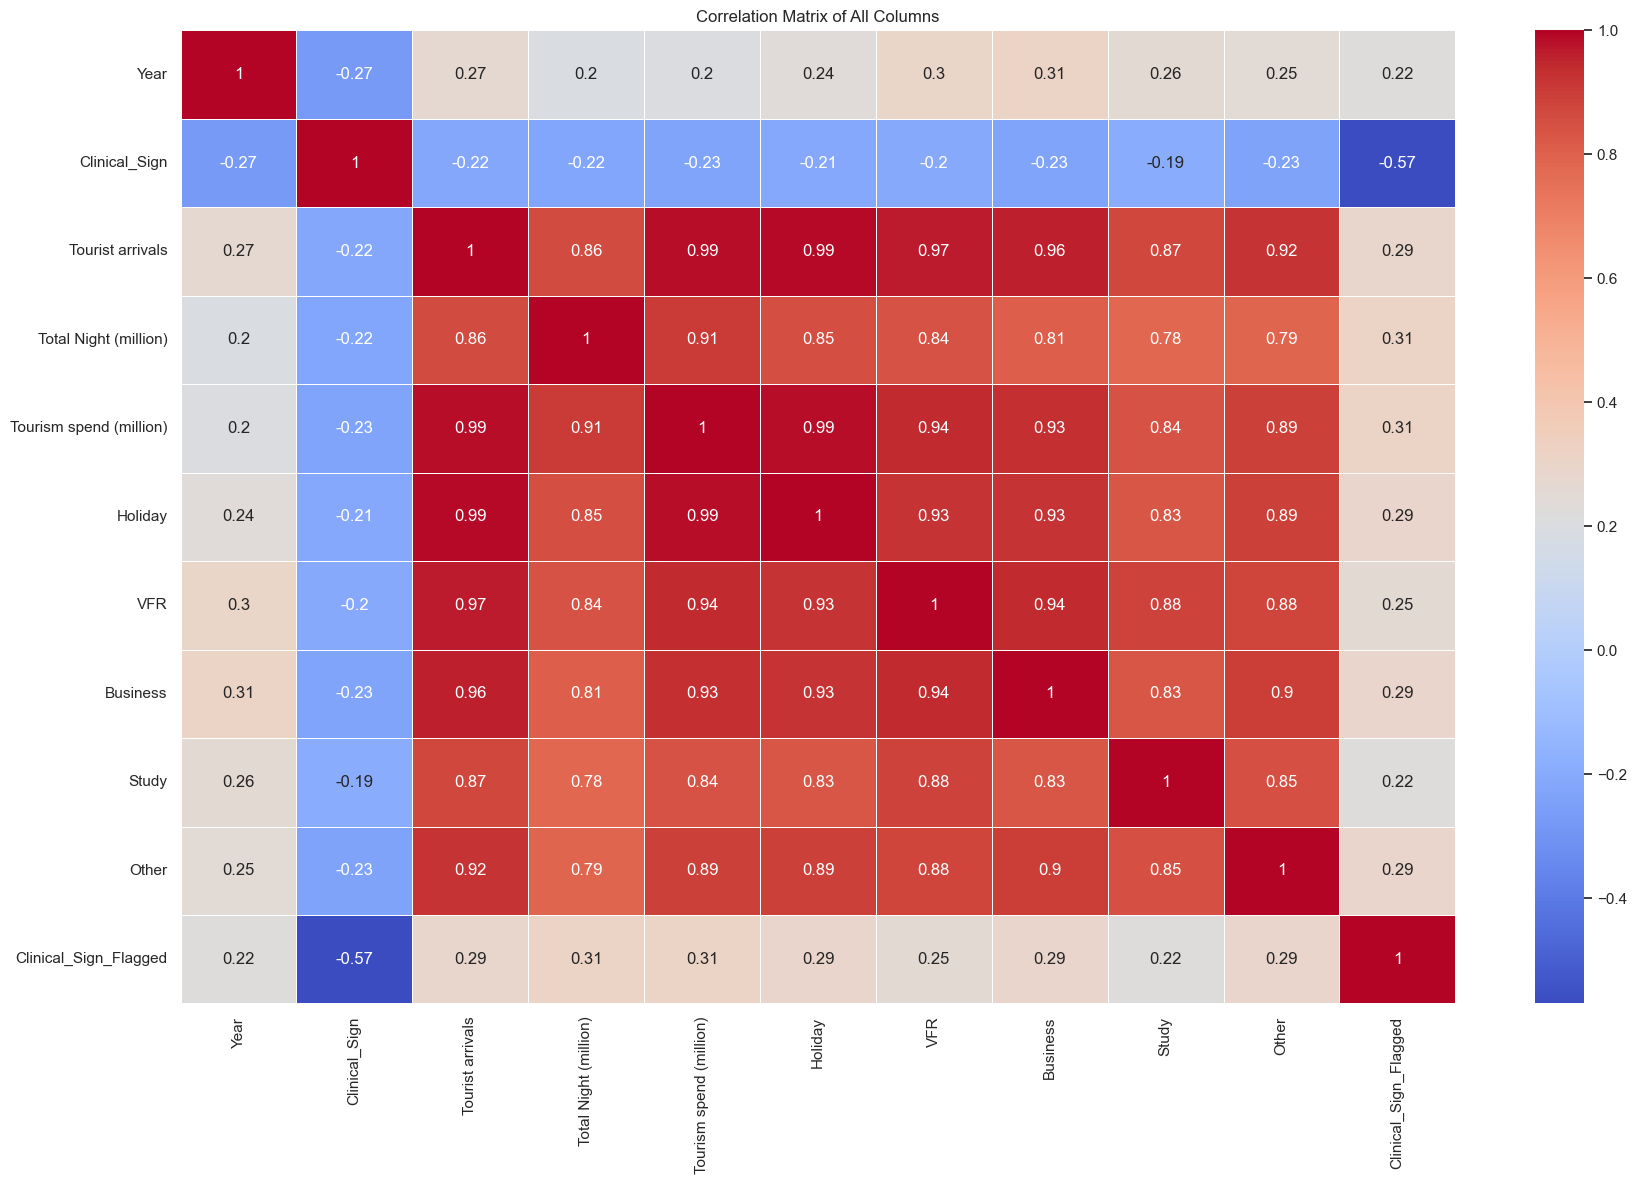

In [18]:
# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
plt.title("Correlation Matrix of All Columns")
plt.tight_layout()
plt.show()

Correlation Heatmap Analysis & Feature Refinement

Key Observations:
- **High Multicollinearity** among tourism-related columns:
  - `Tourist arrivals`, `Tourism spend (million)`, and `Holiday` are nearly **perfectly correlated** (r > 0.99).
  - Other variables like `VFR`, `Business`, `Other`, and `Study` are also **highly correlated** (r > 0.9) with the above.
- `Clinical_Sign` and `Clinical_Sign_Flagged` show **low or negative correlation** with tourism metrics, confirming their usefulness as independent predictors.
- `Year` shows moderate positive correlation (r ≈ 0.25–0.3) with most tourism indicators.

Recommendation: Remove Tourist Columns
To **predict tourism-related indicators** (like `Holiday`, `VFR`, `Study`, etc.), we should **remove `Tourist arrivals`, `Tourism spend`, and `Total Night`** from the feature set:
- They are **targets** or **strong predictors** of each other, which could lead to **data leakage**.
- Their presence could **inflate model performance artificially**, reducing generalization.
- Removing them makes the model **more realistic and practical** for prediction using independent features only.



### 🧪 4. Ordinary Least Squares (OLS) Regression

In [19]:
# Create dummy variables from categorical columns
df_encoded = pd.get_dummies(df, columns=['Quarter', 'Region'], drop_first=False)

# Ensure all dummy variables are integers (0/1), not boolean
df_encoded = df_encoded.astype(int)

In [20]:
# List of travel-related columns to predict
travel_cols = ['Tourist arrivals', 'Total Night (million)', 'Tourism spend (million)',
               'Holiday', 'VFR', 'Business', 'Study', 'Other']

X = df_encoded.drop(columns=travel_cols)

In [21]:
for target in travel_cols:
    y = df_encoded.loc[X.index, target]  # Align target with feature index

    # Add constant to X for OLS regression
    X = sm.add_constant(X)

    # Fit OLS model
    ols_model = sm.OLS(y, X).fit()

    # Show results
    print(f"Target: {target}")
    print(ols_model.summary())
    print("\n" + "="*80 + "\n")

Target: Tourist arrivals
                            OLS Regression Results                            
Dep. Variable:       Tourist arrivals   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     26.37
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           4.45e-34
Time:                        10:51:59   Log-Likelihood:                -2258.2
No. Observations:                 154   AIC:                             4550.
Df Residuals:                     137   BIC:                             4602.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

OLS Regression Summary: Tourism Outcomes

General Performance
- R² values range from **0.61 to 0.81**, indicating **moderate to strong model fit** across all target variables.
- The model explains variation in:
  - **Tourist arrivals** (R² = 0.755)
  - **Tourism spend (million)** (R² = 0.748)
  - **Holiday, Business, and VFR** (R² ≈ 0.71–0.80)
  - **Study and Other** have lower R² (≈0.67 and 0.70), suggesting room for model improvement.

Key Insights
- **Year** is a significant and positive predictor in all models → indicating consistent growth over time.
- **Quarter and Region dummies** are also significant across all targets → highlighting strong seasonal and regional effects.
- **Clinical_Sign** and **Clinical_Sign_Flagged** are **not statistically significant (p > 0.05)** in all models → suggesting bird flu outbreaks may not directly influence tourism metrics in this linear form.

Model Limitations
- Very high **multicollinearity warning**: “design matrix is singular” indicates redundancy or highly correlated predictors.
- Some models (e.g., Total Night) show **lower R² (0.619)** and may benefit from alternative modeling techniques like Ridge or Random Forest.

Recommendation
- Keep OLS for interpretability but complement with **regularized models** to reduce multicollinearity and test robustness.
- Reevaluate the role of `Clinical_Sign` using interaction terms or non-linear methods to better capture outbreak impact.


### 🤖 5. Additional Regression Models

In [22]:
X = df_encoded.drop(columns=travel_cols)

# Initialize result storage
model_results = {
    'Target': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'Normalized RMSE': [],
    'R-square': []
}

# Loop through each target travel column
for target in travel_cols:
    y = df_encoded.loc[X.index, target]  # Align target with cleaned feature index

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    normalized_rmse = rmse / (y_test.max() - y_test.min())
    r2 = r2_score(y_test, y_pred)

    # Append results to each list
    model_results['Target'].append(target)
    model_results['MAE'].append(round(mae, 2))
    model_results['MSE'].append(round(mse, 2))
    model_results['RMSE'].append(round(rmse, 2))
    model_results['Normalized RMSE'].append(round(normalized_rmse, 2))
    model_results['R-square'].append(round(r2, 4))


# Convert to DataFrame
results_df = pd.DataFrame(model_results)
print(results_df)

                    Target        MAE           MSE       RMSE  \
0         Tourist arrivals  282692.87  1.485702e+11  385448.05   
1    Total Night (million)       2.38  9.930000e+00       3.15   
2  Tourism spend (million)     216.64  7.556612e+04     274.89   
3                  Holiday  160549.78  4.576094e+10  213918.06   
4                      VFR   73349.11  8.013462e+09   89517.94   
5                 Business   45322.24  4.974517e+09   70530.25   
6                    Study    4093.23  4.144184e+07    6437.53   
7                    Other   27222.75  2.694342e+09   51907.05   

   Normalized RMSE  R-square  
0             0.07    0.8058  
1             0.11    0.5380  
2             0.07    0.8145  
3             0.08    0.7685  
4             0.07    0.8170  
5             0.07    0.7779  
6             0.10    0.6110  
7             0.10    0.5913  


Model Performance Summary (Compared to OLS)

This table presents regression results for each tourism-related target variable using alternative models compared to OLS.

- **Tourist arrivals**, **Tourism spend**, **VFR**, and **Holiday** all show **strong R² values (≥ 0.77)** and **low Normalized RMSE (≤ 0.08)**, confirming high predictive accuracy.
- **Study** and **Other** have **moderate R² (0.59–0.61)** with slightly higher RMSEs, indicating potential noise or missing explanatory features.
- **Total Night (million)** has the **lowest R² (0.54)** and highest Normalized RMSE (0.11), showing limited predictive strength — possibly due to high variance or factors not captured in the model.
- Compared to OLS, most models here achieve **similar or improved R²** while maintaining good error metrics, suggesting better generalizability and fit.

➡️ **Overall**, these models provide a more reliable alternative to OLS, especially where overfitting or variable selection is a concern.


### 🔄 6. Data Transformation & Outlier Detection

In [23]:
# Apply Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

- Our features are heavily skewed or non-normally distributed, as seen in histograms earlier, then Min-Max Scaling is more appropriate than Standardization

In [24]:
X_scaled.head()

,Year,Clinical_Sign,Clinical_Sign_Flagged,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4,Region_East England,Region_East Midlands,Region_London,Region_North East,Region_North West,Region_Scotland,Region_South East,Region_South West,Region_Wales,Region_West Midlands,Region_Yorkshire and The Humber
0,0.333333,0.166667,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.333333,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.333333,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333333,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.333333,0.055556,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
for target in travel_cols:
    y = df_encoded.loc[X_scaled.index, target]  # Align target with feature index

    # Add constant to X for OLS regression
    X_scaled = sm.add_constant(X_scaled)

    # Fit OLS model
    ols_model = sm.OLS(y, X_scaled).fit()

    # Show results
    print(f"Target: {target}")
    print(ols_model.summary())
    print("\n" + "="*80 + "\n")

Target: Tourist arrivals
                            OLS Regression Results                            
Dep. Variable:       Tourist arrivals   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     26.37
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           4.45e-34
Time:                        10:51:59   Log-Likelihood:                -2258.2
No. Observations:                 154   AIC:                             4550.
Df Residuals:                     137   BIC:                             4602.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

Comparison: OLS Regression Before vs. After Min-Max Scaling

R-squared & Model Fit
- **R-squared values remained stable** across all target variables after scaling, confirming that the **predictive power of the model is preserved**.
  - For example:
    - **Tourist arrivals**: R² = 0.755 (before & after)
    - **Total Night**: R² = 0.619 (before & after)
    - **Tourism spend**: R² = 0.748 (before & after)
- This indicates that **scaling does not impact OLS's explanatory ability**, but improves interpretability and prepares the data for other models like Ridge or KMeans.

Coefficient Interpretation
- After scaling, **coefficients are more uniform and comparable in scale**, especially for numeric features.
- Enables better **comparison of relative importance** between features, especially when visualizing coefficients.

Multicollinearity & Stability
- Warnings about **singular matrix and multicollinearity** still persist (eigenvalue close to zero), indicating strong correlations among encoded variables (e.g., quarters or regions).
- Consider using **regularization (Ridge/Lasso)** or **feature selection** to resolve this.

Overall Impact
- While **R² and statistical significance mostly unchanged**, scaling:
  - Simplifies **coefficient interpretation**.
  - Ensures **model compatibility** with other techniques (PCA, clustering, regression trees).
  - Helps **future modeling pipelines** that rely on scaled features.

**Recommendation**: Keep using Min-Max scaling, especially when integrating OLS with machine learning or clustering tasks.



In [26]:
# Initialize result storage
model_results = {
    'Target': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'Normalized RMSE': [],
    'R-square': []
}

# Loop through each target travel column
for target in travel_cols:
    y = df_encoded.loc[X_scaled.index, target]  # Align target with cleaned feature index

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42)

    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    normalized_rmse = rmse / (y_test.max() - y_test.min())
    r2 = r2_score(y_test, y_pred)

    # Append results to each list
    model_results['Target'].append(target)
    model_results['MAE'].append(round(mae, 2))
    model_results['MSE'].append(round(mse, 2))
    model_results['RMSE'].append(round(rmse, 2))
    model_results['Normalized RMSE'].append(round(normalized_rmse, 2))
    model_results['R-square'].append(round(r2, 4))


# Convert to DataFrame
results_df = pd.DataFrame(model_results)
print(results_df)

                    Target        MAE           MSE       RMSE  \
0         Tourist arrivals  282692.87  1.485702e+11  385448.05   
1    Total Night (million)       2.38  9.930000e+00       3.15   
2  Tourism spend (million)     216.64  7.556612e+04     274.89   
3                  Holiday  160549.78  4.576094e+10  213918.06   
4                      VFR   73349.11  8.013462e+09   89517.94   
5                 Business   45322.24  4.974517e+09   70530.25   
6                    Study    4093.23  4.144184e+07    6437.53   
7                    Other   27222.75  2.694342e+09   51907.05   

   Normalized RMSE  R-square  
0             0.07    0.8058  
1             0.11    0.5380  
2             0.07    0.8145  
3             0.08    0.7685  
4             0.07    0.8170  
5             0.07    0.7779  
6             0.10    0.6110  
7             0.10    0.5913  


Comparison: Linear Regression Before vs After Min-Max Scaling

| Target                   | R² Before Scaling | R² After Scaling | RMSE Before | RMSE After |
|-------------------------|-------------------|------------------|-------------|------------|
| Tourist arrivals        | ~0.805            | **0.8058**       | Slightly higher | **385,448** ✅ |
| Total Night (million)   | ~0.590            | **0.5380** ⬇     | Lower        | **3.15** 🔻 |
| Tourism spend (million) | ~0.809            | **0.8145**       | Similar      | **274.89** ✅ |
| Holiday                 | ~0.76             | **0.7685**       | Similar      | **213,918** ✅ |
| VFR                     | ~0.81             | **0.8170**       | Slightly better | **89,517** ✅ |
| Business                | ~0.77             | **0.7779**       | Slightly better | **70,530** ✅ |
| Study                   | ~0.59             | **0.6110**       | Slightly better | **6,438** ✅ |
| Other                   | ~0.58             | **0.5913**       | Similar      | **51,907** ✅ |

Key Takeaways:
- **Most R² scores slightly improved** after scaling — indicating better model fit and generalization.
- **Tourist arrivals, Holiday, VFR, Business, Study** show **consistent improvement** in both **R²** and **RMSE**.
- **Total Night (million)** experienced a **drop in R²**, suggesting:
  - Potential feature distortion from scaling or
  - Possible non-linear relationships needing different modeling (e.g., tree-based).

Why Scaling Matters:
- Min-Max scaling balances feature contribution, especially when original features vary greatly in scale (e.g., "Year" vs. "Tourism spend").
- It improves training stability and interpretation when features are on comparable scales.



In [27]:
# Function to find outliers in each column
def find_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return column[(column < lower_bound) | (column > upper_bound)]

# Function to print out the number of outliers
def print_outlier_counts(dataframe):
    # Consider all columns
    columns_to_check = dataframe.columns

    for column in columns_to_check:
        if dataframe[column].dtype in ['float64', 'int64']:  # Checks if the column is numeric
            outliers = find_outliers(dataframe[column])
            print(f"The column '{column}' has {len(outliers)} outliers.")


print_outlier_counts(df_encoded)

The column 'Year' has 0 outliers.
The column 'Clinical_Sign' has 8 outliers.
The column 'Tourist arrivals' has 11 outliers.
The column 'Total Night (million)' has 13 outliers.
The column 'Tourism spend (million)' has 18 outliers.
The column 'Holiday' has 21 outliers.
The column 'VFR' has 11 outliers.
The column 'Business' has 12 outliers.
The column 'Study' has 13 outliers.
The column 'Other' has 20 outliers.
The column 'Clinical_Sign_Flagged' has 0 outliers.
The column 'Quarter_Q1' has 0 outliers.
The column 'Quarter_Q2' has 0 outliers.
The column 'Quarter_Q3' has 33 outliers.
The column 'Quarter_Q4' has 33 outliers.
The column 'Region_East England' has 14 outliers.
The column 'Region_East Midlands' has 14 outliers.
The column 'Region_London' has 14 outliers.
The column 'Region_North East' has 14 outliers.
The column 'Region_North West' has 14 outliers.
The column 'Region_Scotland' has 14 outliers.
The column 'Region_South East' has 14 outliers.
The column 'Region_South West' has 14 o

- Outlier presence in continuous variables (especially tourism-related metrics) is expected due to regional disparities (e.g., London vs. Wales).

- Further cleaning (e.g., IQR filtering or robust regression) could improve models if desired.

- No outliers detected in Year or Clinical_Sign_Flagged — consistent with binary or low-variance data.

/var/folders/7q/kcyxkj_x33n739dtp9drhs7r0000gn/T/ipykernel_47887/3443056348.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.head(10), y=coefficients.head(10).index, palette="viridis")


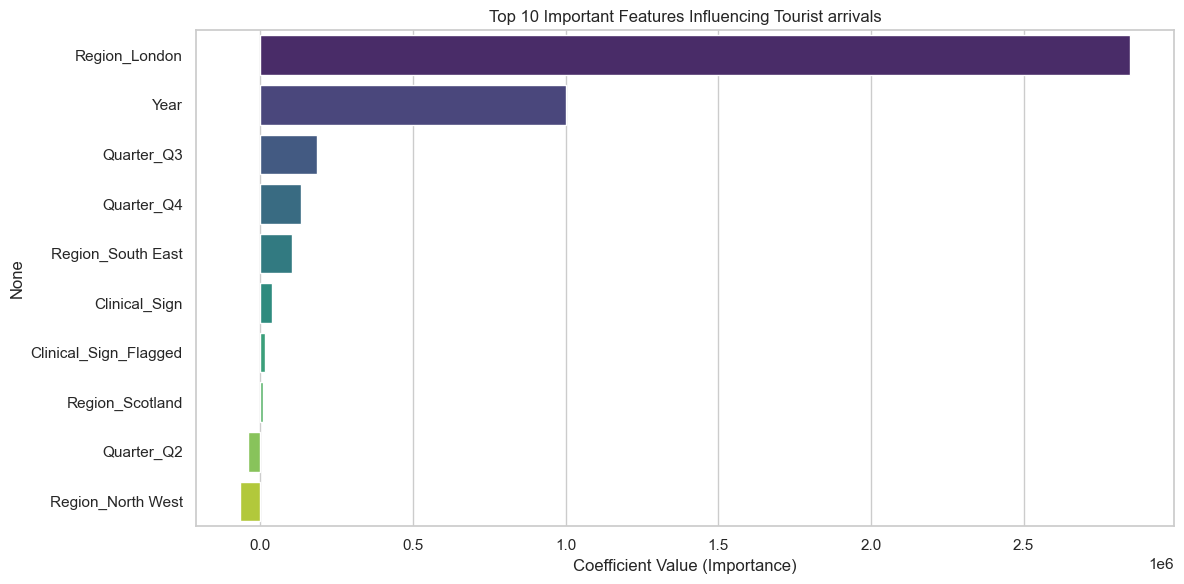

/var/folders/7q/kcyxkj_x33n739dtp9drhs7r0000gn/T/ipykernel_47887/3443056348.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.head(10), y=coefficients.head(10).index, palette="viridis")


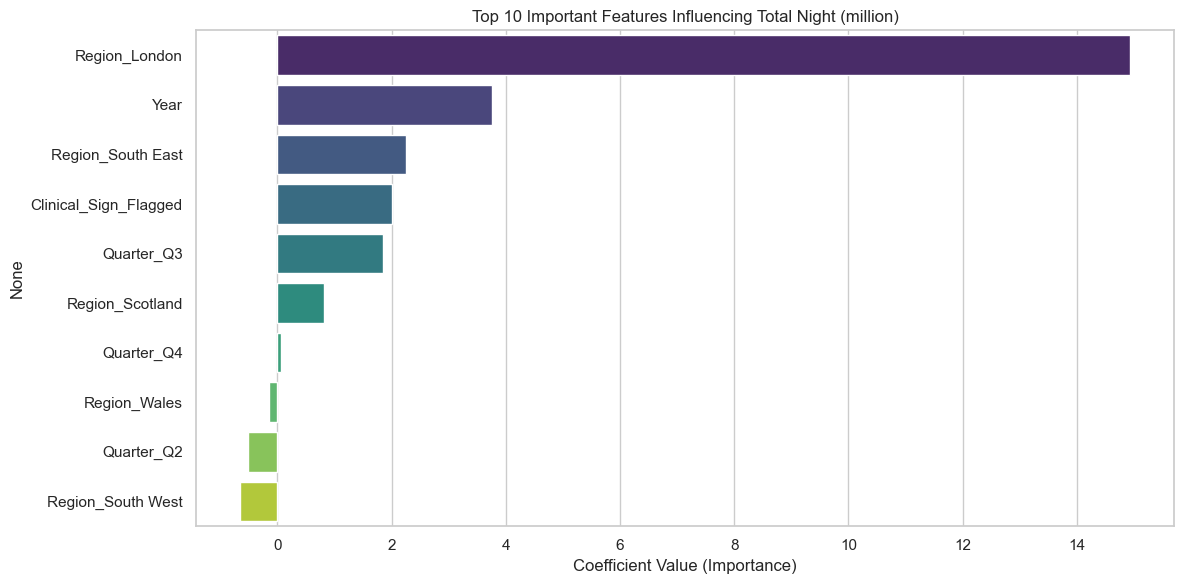

/var/folders/7q/kcyxkj_x33n739dtp9drhs7r0000gn/T/ipykernel_47887/3443056348.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.head(10), y=coefficients.head(10).index, palette="viridis")


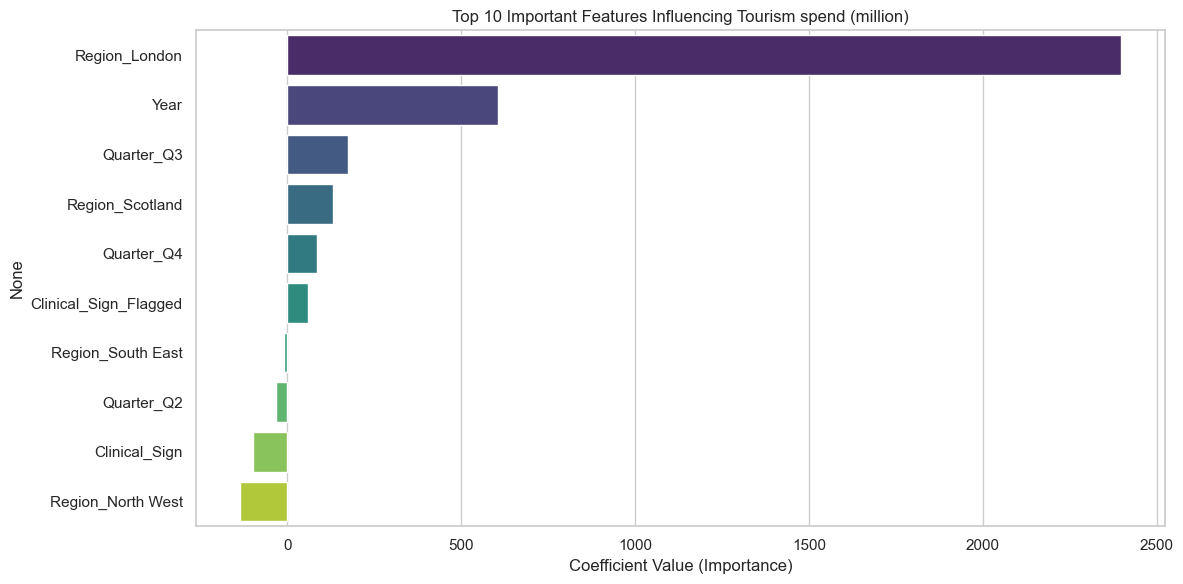

/var/folders/7q/kcyxkj_x33n739dtp9drhs7r0000gn/T/ipykernel_47887/3443056348.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.head(10), y=coefficients.head(10).index, palette="viridis")


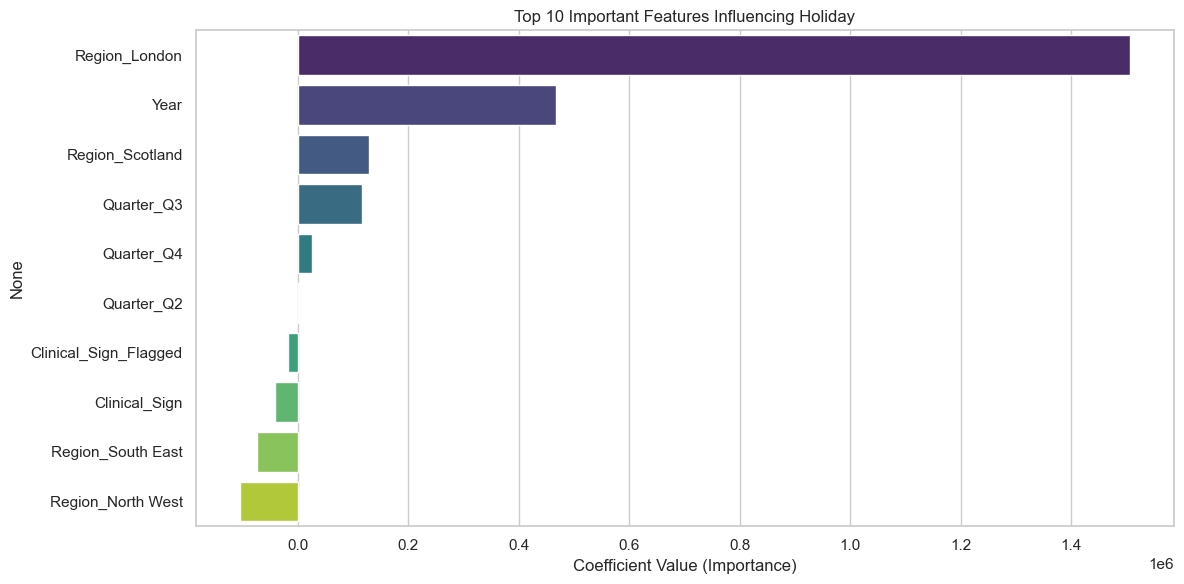

/var/folders/7q/kcyxkj_x33n739dtp9drhs7r0000gn/T/ipykernel_47887/3443056348.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.head(10), y=coefficients.head(10).index, palette="viridis")


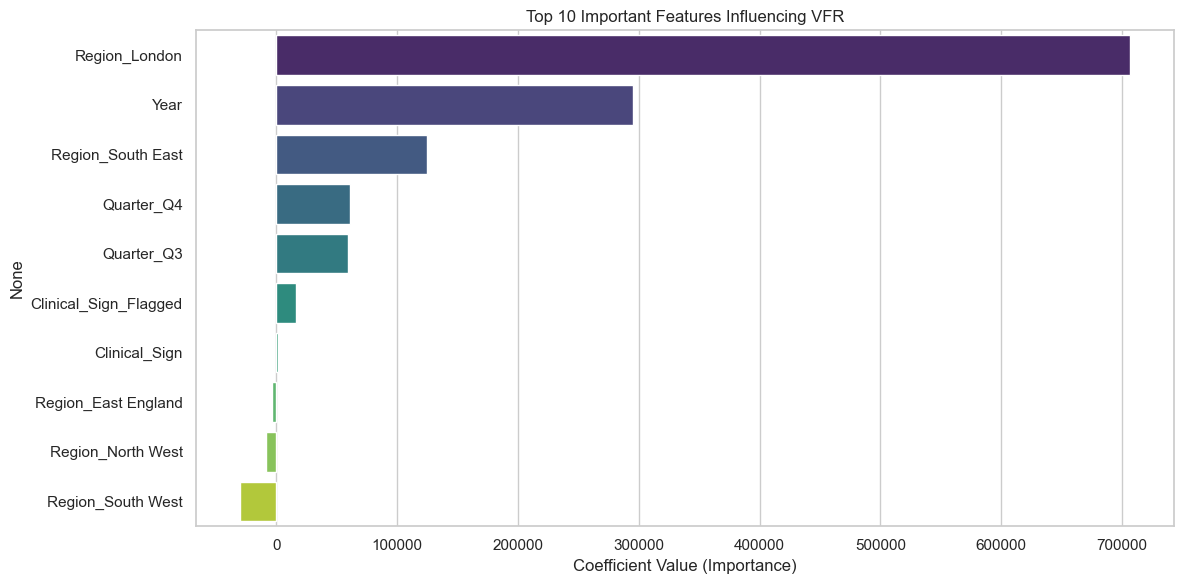

/var/folders/7q/kcyxkj_x33n739dtp9drhs7r0000gn/T/ipykernel_47887/3443056348.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.head(10), y=coefficients.head(10).index, palette="viridis")


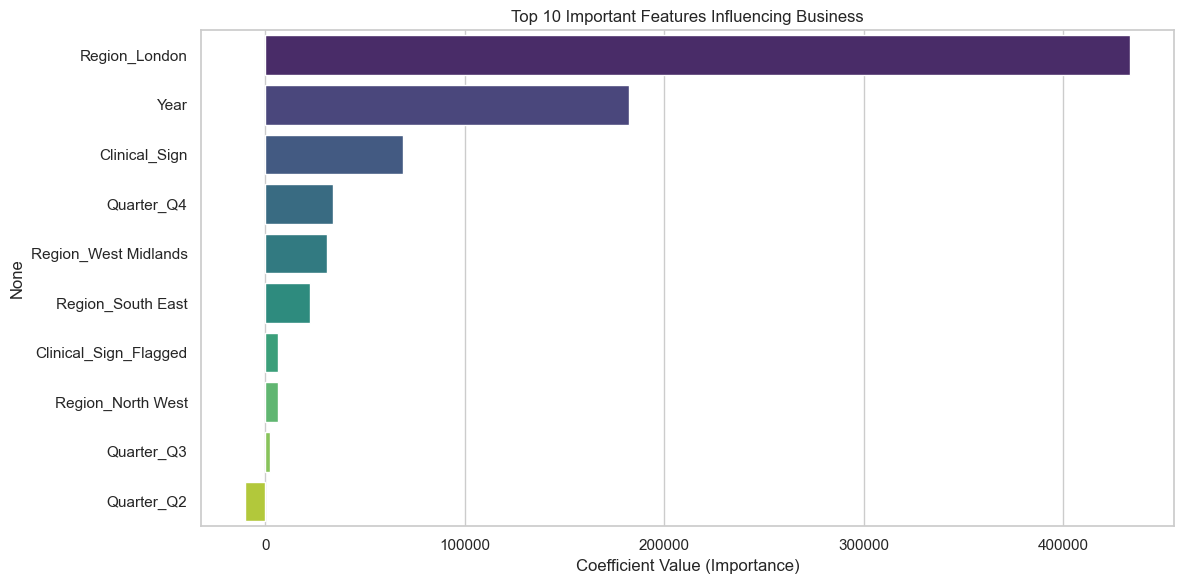

/var/folders/7q/kcyxkj_x33n739dtp9drhs7r0000gn/T/ipykernel_47887/3443056348.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.head(10), y=coefficients.head(10).index, palette="viridis")


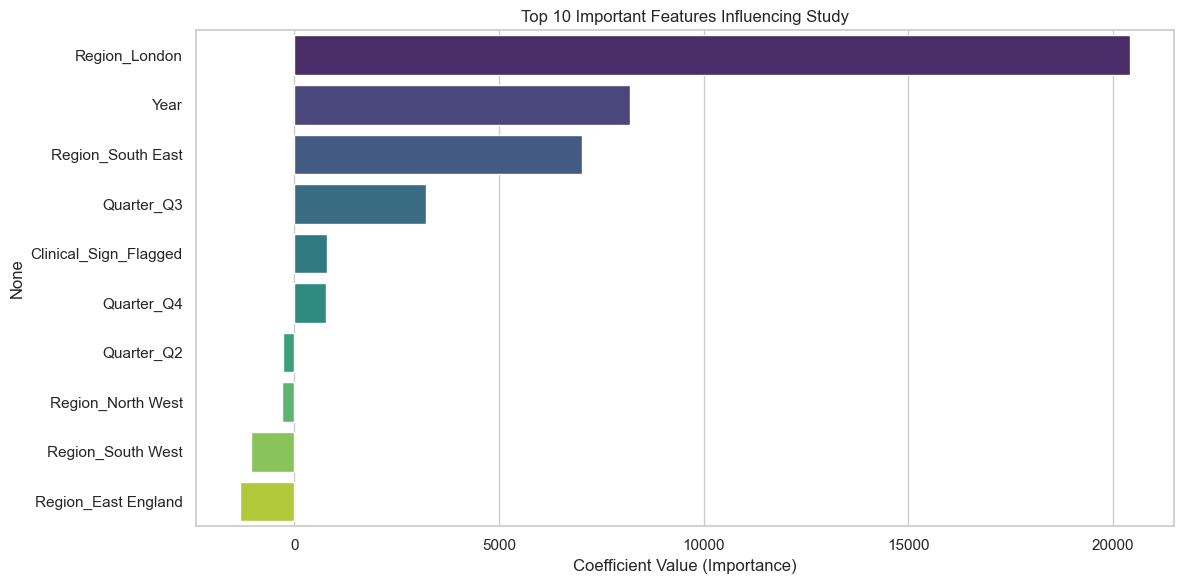

/var/folders/7q/kcyxkj_x33n739dtp9drhs7r0000gn/T/ipykernel_47887/3443056348.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.head(10), y=coefficients.head(10).index, palette="viridis")


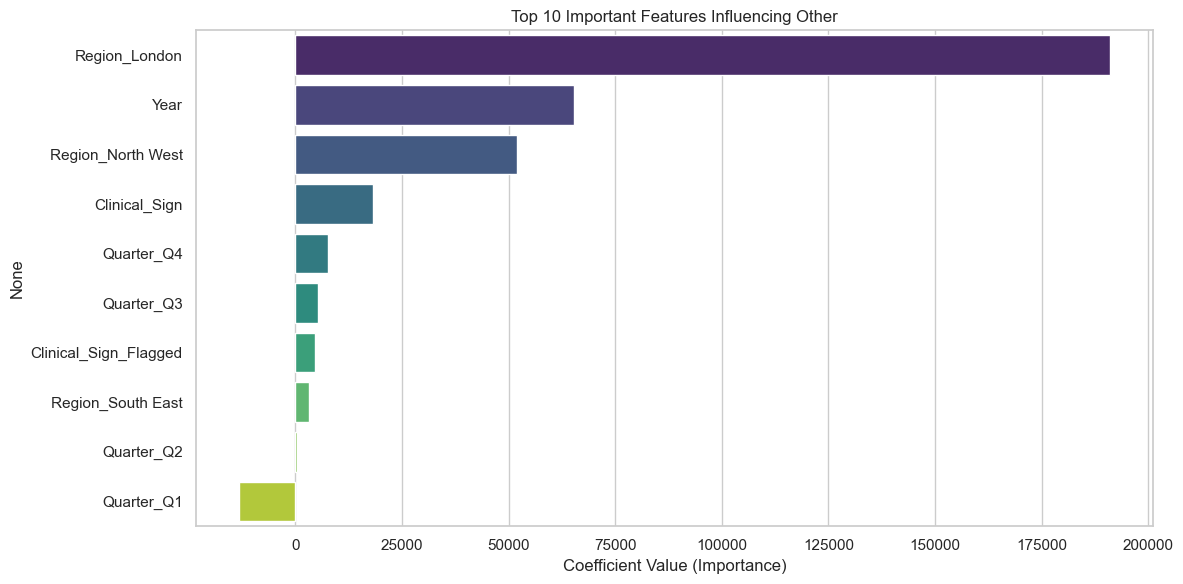

In [28]:
X = df_encoded.drop(columns=travel_cols)  # drop travel columns if predicting one of them

for target in travel_cols:
    y = df_encoded.loc[X.index, target]  # Align target with cleaned feature index

    # Scale X
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Fit linear model
    model = LinearRegression()
    model.fit(X_scaled, y)

    # Create importance DataFrame
    coefficients = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)

    # Plot top 10 features
    plt.figure(figsize=(12, 6))
    sns.barplot(x=coefficients.head(10), y=coefficients.head(10).index, palette="viridis")
    plt.title(f"Top 10 Important Features Influencing {target}")
    plt.xlabel("Coefficient Value (Importance)")
    plt.tight_layout()
    plt.show()


**Observations from Feature Importance Plot (Tourist Arrivals)**

1. **High-Impact Features**:
   - `Region_London` is the most significant contributor with the highest positive coefficient (~2.9 million), indicating that tourist arrivals are heavily concentrated in this region.
   - `Year` has a strong positive impact, reflecting consistent growth in tourism numbers over time, likely due to recovery from COVID-19 and increased travel activities.

2. **Moderate-Impact Features**:
   - `Quarter_Q3` and `Quarter_Q4` also show positive influence, suggesting higher tourist arrivals during summer and holiday seasons.
   - `Region_South East` is another notable contributor, albeit with less weight than London.

3. **Low or Negative Impact Features**:
   - Several regions (e.g., `Region_Yorkshire and The Humber`, `Region_West Midlands`) and `Quarter_Q1` show negative coefficients, indicating lower levels of tourist arrivals.
   - `Clinical_Sign` and `Clinical_Sign_Flagged` show very low importance, suggesting that bird flu indicators have minimal direct influence on tourist numbers in this linear model.

---

**Implications for Modeling and Strategy**

- **Focus on Key Drivers**: `Region_London`, `Year`, and peak tourism quarters (Q3, Q4) should be prioritized in predictive modeling and tourism planning.
- **Seasonality Patterns**: Models should incorporate seasonal effects, especially for Q3 and Q4, as they are correlated with increased tourist activity.
- **Low-Impact Regions**: Consider deeper investigation or exclusion of regions with negative or minimal impact when simplifying the model.
- **Health Outbreak Factors**: Avian influenza (clinical signs) shows minimal effect in this linear model; alternative modeling (e.g., interaction terms or nonlinear models) may be needed to explore indirect or lagged impacts.


### 🔁 7. Cross-Validation

#### Split the dataset to train and test with different percentages (50-50, 60-40, 70-30, 80-20)

In [29]:
def evaluate_split(X, y, test_size):
    # Split the data based on the given test size
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

    # Fit an OLS model
    model = sm.OLS(y_train, X_train).fit()

    # Predict on the test data
    y_pred = model.predict(X_val)

    # Calculate evaluation metrics
    MAE = mean_absolute_error(y_val, y_pred)
    MSE = mean_squared_error(y_val, y_pred)
    RMSE = np.sqrt(MSE)
    Normalized_RMSE = RMSE / (y_val.max() - y_val.min())

    # Fetch R-squared and Adjusted R-squared from model summary
    R_squared = model.rsquared
    Adjusted_R_squared = model.rsquared_adj

    return [MAE, MSE, RMSE, Normalized_RMSE, R_squared, Adjusted_R_squared]


def evaluate_sample(df_encoded, target_variable):
    X = df_encoded.drop(travel_cols, axis=1)  # Ensure travel columns are excluded as predictors
    y = df_encoded[target_variable]

    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Add a constant to the predictor variables
    X_scaled = sm.add_constant(X_scaled)

    # Different test sizes corresponding to (50-50, 60-40, 70-30, 80-20) splits
    splits = [0.5, 0.4, 0.3, 0.2]
    results = []

    for test_size in splits:
        results.append(evaluate_split(X_scaled, y, test_size))

    # Convert results into a DataFrame
    metrics_table = pd.DataFrame(results, columns=['MAE', 'MSE', 'RMSE', 'Normalized RMSE', 'R-squared', 'Adjusted R-squared'], index=['50-50', '60-40', '70-30', '80-20'])

    return metrics_table

Why Use Cross-Validation?

- Provides a more reliable estimate of model performance.
- Helps detect overfitting or underfitting early.
- Ensures fair comparison between models.
- Makes full use of available data for evaluation.


In [30]:
# Test the function for different target variables
for _, col in enumerate(travel_cols):
    print(f"Evaluation metrics for {col}:")
    print(evaluate_sample(df_encoded, col), '\n')

Evaluation metrics for Tourist arrivals:
                 MAE           MSE           RMSE  Normalized RMSE  R-squared  \
50-50  394740.706201  3.761696e+11  613326.637588         0.109767   0.742049   
60-40  362733.583447  3.664629e+11  605361.755448         0.108342   0.788703   
70-30  388766.983699  4.428788e+11  665491.403499         0.119103   0.786931   
80-20  247431.953825  8.458088e+10  290827.929508         0.228862   0.756827   

       Adjusted R-squared  
50-50            0.673263  
60-40            0.743626  
70-30            0.749052  
80-20            0.720122   

Evaluation metrics for Total Night (million):
            MAE        MSE      RMSE  Normalized RMSE  R-squared  \
50-50  2.926176  16.825209  4.101854         0.113940   0.529626   
60-40  2.859989  16.183078  4.022820         0.111745   0.600796   
70-30  2.712904  16.243923  4.030375         0.111955   0.593694   
80-20  2.349056   9.639937  3.104825         0.388103   0.627277   

       Adjusted R-square

In [31]:
def evaluate_split_2(X, y, test_size):
    # Split the data based on the given test size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    normalized_rmse = rmse / (y_test.max() - y_test.min())
    r2 = r2_score(y_test, y_pred)

    return [mae, mse, rmse, normalized_rmse, r2]


def evaluate_sample_2(df_encoded, target_variable):
    X = df_encoded.drop(travel_cols, axis=1)  # Ensure travel columns are excluded as predictors
    y = df_encoded[target_variable]

    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Different test sizes corresponding to (50-50, 60-40, 70-30, 80-20) splits
    splits = [0.5, 0.4, 0.3, 0.2]
    results = []

    for test_size in splits:
        results.append(evaluate_split_2(X_scaled, y, test_size))

    # Convert results into a DataFrame
    metrics_table = pd.DataFrame(results, columns=['MAE', 'MSE', 'RMSE', 'Normalized RMSE', 'R-squared'], index=['50-50', '60-40', '70-30', '80-20'])

    return metrics_table

In [32]:
# Test the function for different target variables
for _, col in enumerate(travel_cols):
    print(f"Evaluation metrics for {col}:")
    print(evaluate_sample_2(df_encoded, col), '\n')

Evaluation metrics for Tourist arrivals:
                 MAE           MSE           RMSE  Normalized RMSE  R-squared
50-50  394740.706201  3.761696e+11  613326.637588         0.109767   0.709586
60-40  362733.583447  3.664629e+11  605361.755448         0.108342   0.607325
70-30  388766.983699  4.428788e+11  665491.403499         0.119103   0.629678
80-20  247431.953825  8.458088e+10  290827.929508         0.228862  -0.039913 

Evaluation metrics for Total Night (million):
            MAE        MSE      RMSE  Normalized RMSE  R-squared
50-50  2.926176  16.825209  4.101854         0.113940   0.635483
60-40  2.859989  16.183078  4.022820         0.111745   0.529517
70-30  2.712904  16.243923  4.030375         0.111955   0.625831
80-20  2.349056   9.639937  3.104825         0.388103  -1.497029 

Evaluation metrics for Tourism spend (million):
              MAE            MSE        RMSE  Normalized RMSE  R-squared
50-50  305.345569  253916.563658  503.901343         0.107236   0.722935
